In [44]:
import os
import sys
import warnings
warnings.simplefilter("error", RuntimeWarning)
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("./"), '..')))

import plot_settings
import random
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.stats import norm

In [45]:
#UTILS

# This function is used to print a progress bar
def print_progress(current_status, total, more_info="", bar_length = 30):
    print(f"\r {current_status}/{total} [", end="")
    printed_progress = False
    for current in range(bar_length):
        if current / bar_length < current_status / total:
            print("=", end="")
        else:
            if(not printed_progress):
                print(">",end="")
            else:
                print(".", end="")
            printed_progress = True
    print("]"+more_info, end="")

In [46]:
# Angular distribution described in
# section 6.8 cowel.
def pdf(x, a, b, x_min, x_max):
    numerator = 1 + a * x + b * x**2
    normalization = (x_max-x_min) + (a/2)*(x_max**2-x_min**2) + (b/3)*(x_max**3-x_min**3)
    result = numerator / normalization

    return result

# This function performs a safe logarithmic calculation. 
# It wraps np.log in a try-except block. 
# If an exception occurs, the function returns 
# a large value to penalize invalid inputs.
def safe_log(x, a, b, x_min, x_max):
    try:
        return np.log(pdf(x, a, b, x_min, x_max)) 
    except Warning as e:
        return np.log(1e-10)
    

# Log-likelihood function
def log_likelihood(data, x_min, x_max):
    def log_likelihood_lambda(params):
        a, b = params
        likelihoods = [
            safe_log(x, a, b, x_min, x_max)
            for x in data
        ]
        return -np.sum(likelihoods) 
    return lambda params: log_likelihood_lambda(params)

# This function is used to estimate
# a and b parameters for the pdf function
# using the maximum likelihood method
def estimate_a_b(data, x_min, x_max):
    # Parameter estimation with initial values
    initial_guess = [0.5, 0.5]

    # Minimizing log likelihood
    result = minimize(
        log_likelihood(data, x_min, x_max), 
        initial_guess, 
        method="BFGS",
        tol=1e-20
    )

    # Results
    a, b = result.x   
    

    # Errors estimated from the covariance matrix
    cov_matrix = result.hess_inv
    errors = np.sqrt(np.diag(cov_matrix))
    covariance = cov_matrix[0, 1]

    resulting_pdf = lambda x : pdf(x, a, b, x_min, x_max) 

    return a, b, errors, covariance, resulting_pdf


Estimated a: 0.332 +/- 0.059
Estimated b: 0.764 +/- 0.210
Estimated covariance 0.004
Estimated covariance coefficent 0.340


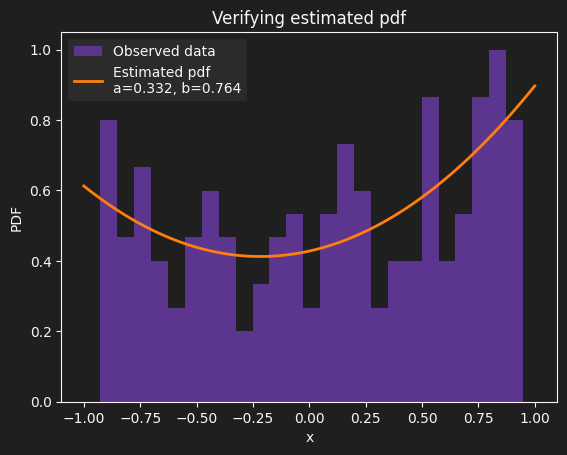

In [47]:
data = np.loadtxt("data_proj_one.dat")
data_min = -0.95
data_max = 0.95


a, b, errors, covariance, estimated_pdf = estimate_a_b(data, data_min, data_max)

print(f"Estimated a: {a:.3f} +/- {errors[0]:.3f}")
print(f"Estimated b: {b:.3f} +/- {errors[1]:.3f}")
print(f"Estimated covariance {covariance:.3f}")
correlation_coeff = covariance /(errors[0] * errors[1])
print(f"Estimated covariance coefficent {correlation_coeff:.3f}")

fig, ax = plot_settings.figure_ax()

# Generation of points for the estimated distribution
x_values = np.linspace(-1, 1, 500)
pdf_values = [estimated_pdf(x) for x in x_values]

# Plot comparison between histogram of data and the estimated curve
ax.hist(data, bins=25, density=True, color=plot_settings.color(1), label='Observed data')
ax.plot(x_values, pdf_values, plot_settings.color(5), linewidth=2, label=f'Estimated pdf\na={a:.3f}, b={b:.3f}')
plot_settings.title('Verifying estimated pdf'),
plot_settings.set_plot_theme(ax, ylabel='PDF')

plt.show()

In [48]:
def rcf(n, a_value, b_value, x_min_value, x_max_value):
    # Defining symbols
    x, a, b = sp.symbols('x a b')
    x_min, x_max = sp.symbols('x_max x_min', real=True)

    # PDF 
    sp_pdf = pdf(x, a, b, x_min, x_max)

    # pdf log
    log_likelihood = sp.log(sp_pdf)

    # Computing second derivatives
    second_derivative_a = sp.lambdify(
        (x, a, b, x_min, x_max), 
        sp.diff(log_likelihood, a, a), 
        'numpy'
    )
    second_derivative_b = sp.lambdify(
        (x, a, b, x_min, x_max), 
        sp.diff(log_likelihood, b, b), 
        'numpy'
    )
    second_derivative_ab = sp.lambdify(
        (x, a, b, x_min, x_max), 
        sp.diff(log_likelihood, a, b), 
        'numpy'
    )

    # Converting derivatives to function of x:
    second_derivative_a_func =  lambda x_var: second_derivative_a(x_var, a_value, b_value, x_min_value, x_max_value)
    second_derivative_b_func =  lambda x_var: second_derivative_b(x_var, a_value, b_value, x_min_value, x_max_value)
    second_derivative_ab_func = lambda x_var: second_derivative_ab(x_var, a_value, b_value, x_min_value, x_max_value)

    # Computing fisher information matrix
    I_aa = n * quad(lambda x: - estimated_pdf(x) * second_derivative_a_func(x), x_min_value, x_max_value)[0]
    I_bb = n * quad(lambda x: - estimated_pdf(x) * second_derivative_b_func(x), x_min_value, x_max_value)[0]
    I_ab = n * quad(lambda x: - estimated_pdf(x) * second_derivative_ab_func(x), x_min_value, x_max_value)[0]
    V_Inv = np.array([[I_aa, I_ab], [I_ab, I_bb]])

    # Inverting V_Inv to get V
    V = np.linalg.inv(V_Inv)
    return V
    

In [49]:
# This function is used to get the
# the estimated pdf maximum.
def get_pdf_maximum(e_pdf):    
    return np.max([e_pdf(data_min),e_pdf(data_max)])

# Function for random generation
# using the Monte Carlo method
def generate_random_monte_carlo(pdf, pdf_maximum, n_samples, x_min, x_max):
    samples = []
    while len(samples) < n_samples:
        sample = random.uniform(x_min,x_max)
        random_picker = random.uniform(0,pdf_maximum)
        if(pdf(sample) >= random_picker):
            samples.append(sample)
    return samples

In [50]:
1 /(get_pdf_maximum(estimated_pdf) * (0.95) * 2)

0.6133156862379583

In [51]:
estimated_a = []
estimated_b = []

estimated_variance_a = 0
estimated_variance_b = 0

pdf_max = get_pdf_maximum(estimated_pdf)

# Making 500 simulations
num_simulations = 3000
num_elements = 200
tot = 0
print_progress(0, num_simulations)
for current in range(1, num_simulations + 1):
    new_x = generate_random_monte_carlo(estimated_pdf, pdf_max, num_elements, data_min, data_max)

    print_progress(current,num_simulations)
    new_a,new_b, errors_mc, covariance, npdf = estimate_a_b(new_x, data_min, data_max)

    estimated_a.append(new_a)
    estimated_b.append(new_b)

    estimated_variance_a += (new_a - a) ** 2
    estimated_variance_b += (new_b - b) ** 2
    tot += i

estimated_variance_a = estimated_variance_a / (num_simulations - 1)
estimated_variance_b = estimated_variance_b / (num_simulations - 1)
print("")

 3000/3000 [==============================]


In [52]:
print(f"Estimated varaiance with {num_elements} elements using MC")
print(f"Estimated varaiance of a: {estimated_variance_a}")
print(f"Estimated varaiance of b: {estimated_variance_b}")
print("")
covariance_matrix = rcf(num_elements, a, b, data_min, data_max)
print(f"Estimated varaiance with {num_elements} elements using RCF")
print(f"Estimated varaiance of a: {covariance_matrix[0][0]}")
print(f"Estimated varaiance of b: {covariance_matrix[1][1]}")

Estimated varaiance with 200 elements using MC
Estimated varaiance of a: 0.030881022768935205
Estimated varaiance of b: 0.18572260919841713

Estimated varaiance with 200 elements using RCF
Estimated varaiance of a: 0.029878459927591073
Estimated varaiance of b: 0.16551189152635493


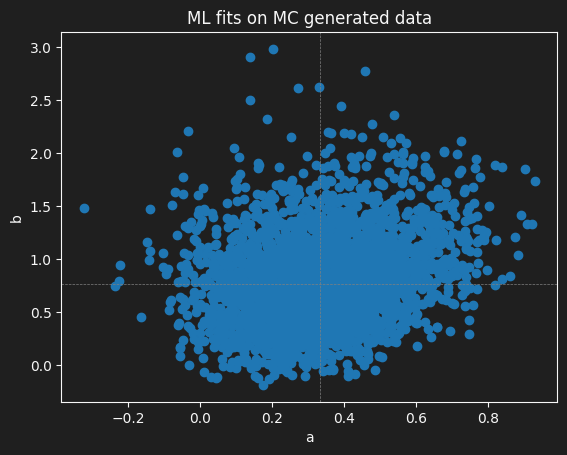

In [53]:
# Visualizations of data generated via Monte Carlo
from matplotlib.patches import Ellipse
mc_a = np.mean(estimated_a)
mc_b = np.mean(estimated_b)
 

# Creazione della figura
fig, ax = plot_settings.figure_ax()

plot_settings.title('ML fits on MC generated data')    
ax.scatter(estimated_a,estimated_b,)

# Assi e dettagli

ax.axhline(b, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(a, color='gray', linestyle='--', linewidth=0.5)

plot_settings.set_plot_theme(ax, xlabel='a',ylabel='b', show_legend=False)

In [54]:
def plot_marginal_distribution(values, title, xlabel) : 
    _, ax = plot_settings.figure_ax()
    ax.hist(values, bins=60, density=True, alpha=0.6, color=plot_settings.color(1))
    plot_settings.title(title) 
    ax.set_xlabel(xlabel)

    mean = np.mean(values)
    error = np.std(values)

    x = np.linspace(mean - 4*error, mean + 4*error, 1000)
    pdf = norm.pdf(x, mean, error)

    plt.plot(x, pdf, lw=2, label="Gaussian fit", c=plot_settings.color(5))
    plot_settings.set_plot_theme(ax)
    plt.show()
    print(f"Estimated {xlabel}: {mean:.3f} +/- {error:.3f}")

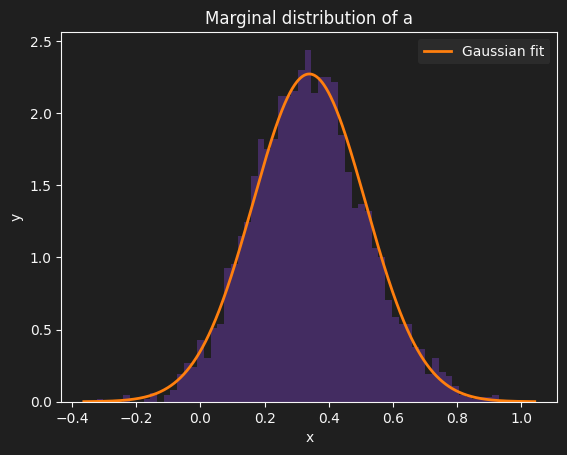

Estimated a: 0.339 +/- 0.176


In [55]:
plot_marginal_distribution(estimated_a, 'Marginal distribution of a', 'a')

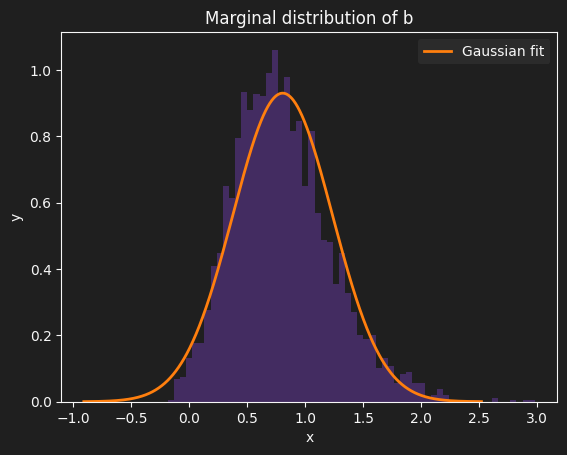

Estimated b: 0.807 +/- 0.429


In [56]:
plot_marginal_distribution(estimated_b, 'Marginal distribution of b', 'b')